# By using Tensorflow

In [1]:
from keras.models import Model, Sequential
from keras. layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate
from keras.optimizers import Adam
import sys
import glob
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model
from keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np
# Step 1: Set up Google Drive access
#from google.colab import drive
#drive.mount('/content/drive')
#  path to dataset on Google Drive


2023-11-13 10:06:10.968351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 10:06:37.844433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-13 10:06:37.844493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-13 10:06:39.540505: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 10:06:55.998954: W tensorflow/stream_executor/platform/de

In [2]:
dataset_path = 'ImageToImage/train'

In [106]:
# Function to load and preprocess images
def load_images(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3) # Modify based on your image format
    img = tf.image.resize(img, (128, 128)) # Adjust the size
    img = tf.cast(img, tf.float32)
    
    # Normalize based on provided mean and std values
    mean = [0.485, 0.456, 0.406]  # Mean values from your PyTorch transforms
    std = [0.229, 0.224, 0.225]   # Standard deviation values from your PyTorch transforms
    img = (img - mean) / std

    return img


# Dataset paths for RGB and Thermal images
rgb_path = "ImageToImage/train/rgb"
thermal_path = "ImageToImage/train/thermal"
rgb_images = os.listdir(rgb_path)
thermal_images = os.listdir(thermal_path)

# Generator (UNet)
def GeneratorUnet():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    down1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(down1)
    down3 = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(down2)
    down4 = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', activation='relu')(down3)
    down5 = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', activation='relu')(down4)

    # Decoder
    up1 = layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', activation='relu')(down5)
    up2 = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(up1)
    up3 = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(up2)
    up4 = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(up3)
    up5 = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')(up4)

    return Model(inputs=inputs, outputs=up5)

# Discriminator
def Discriminator():
    inputs = layers.Input(shape=(128, 128, 3))

    conv1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(inputs)
    conv2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(conv1)
    conv3 = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(conv2)
    conv4 = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', activation='relu')(conv3)
    conv5 = layers.Conv2D(1, (4, 4), strides=(2, 2), padding='same')(conv4)

    return Model(inputs=inputs, outputs=conv5)

# Initialize GAN components
generator = GeneratorUnet()
discriminator = Discriminator()

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


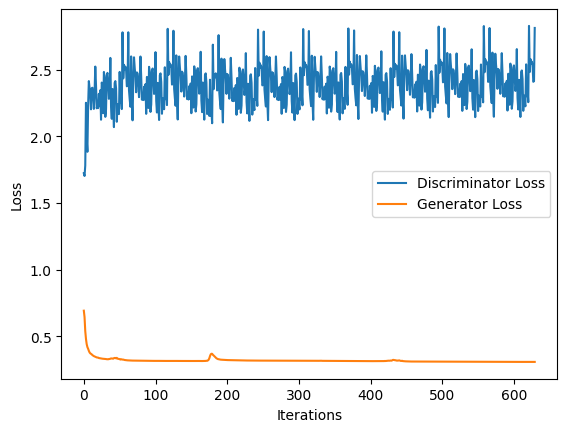

In [107]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

discriminator.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
discriminator.trainable = False

input_rgb = layers.Input(shape=(128, 128, 3))
fake_thermal = generator(input_rgb)
validity = discriminator(fake_thermal)

gan = Model(input_rgb, validity)
gan.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Training loop
num_epochs = 10
batch_size = 16
losses_d = []  # To store discriminator losses
losses_g = []  # To store generator losses
# Set the checkpoint directory
checkpoint_dir = 'ImageToImage/tensorflow/'
os.makedirs(checkpoint_dir, exist_ok=True)
# Define the checkpoint file path
#checkpoint_path = checkpoint_dir + 'cp.ckpt'
# Create a ModelCheckpoint callback

'''checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Set to True to save only the model weights
    save_freq='epoch'  # Save after each epoch
)'''

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    for i in range(0, len(rgb_images), batch_size):
        rgb_batch = []
        thermal_batch = []

        for j in range(i, min(i + batch_size, len(rgb_images))):
            rgb_img = load_images(os.path.join(rgb_path, rgb_images[j]))
            thermal_img = load_images(os.path.join(thermal_path, thermal_images[j]))
            rgb_batch.append(rgb_img)
            thermal_batch.append(thermal_img)

        rgb_batch = tf.convert_to_tensor(rgb_batch)
        thermal_batch = tf.convert_to_tensor(thermal_batch)

        with tf.GradientTape() as tape:
            fake_thermal = generator(rgb_batch, training=True)
            real_output = discriminator(thermal_batch, training=True)
            fake_output = discriminator(fake_thermal, training=True)

            real_loss = loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
            total_dis_loss = real_loss + fake_loss

        dis_gradients = tape.gradient(total_dis_loss, discriminator.trainable_variables)
        optimizer.apply_gradients(zip(dis_gradients, discriminator.trainable_variables))

        with tf.GradientTape() as tape:
            fake_thermal = generator(rgb_batch, training=True)
            fake_output = discriminator(fake_thermal, training=True)
            gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)

        gen_gradients = tape.gradient(gen_loss, generator.trainable_variables)
        optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        if (i + 1) % 2 == 0:
          print(f"Discriminator Loss: {total_dis_loss:.4f}, Generator Loss: {gen_loss:.4f}")

        # Log the losses
        losses_d.append(total_dis_loss)
        losses_g.append(gen_loss)
    #---------------------------------------------------------------------------------------------------------------------------------
        # Save the models after 10 epochs by json format
    if (epoch + 1) % 5 == 0:
        generator.save(os.path.join(checkpoint_dir, f'generator_model_{epoch + 1}.h5'))
        discriminator.save(os.path.join(checkpoint_dir, f'discriminator_model_{epoch + 1}.h5'))
        gan.save(os.path.join(checkpoint_dir, f'gan_model_{epoch + 1}.h5'))
        
        # Save generator architecture as JSON
        generator_json = generator.to_json()
        with open(os.path.join(checkpoint_dir, f'generator_architecture_{epoch + 1}.json'), "w") as json_file:
            json_file.write(generator_json)
        # Save generator weights
        generator.save_weights(os.path.join(checkpoint_dir, f'generator_weights_{epoch + 1}.h5'))

        # Save discriminator architecture as JSON
        discriminator_json = discriminator.to_json()
        with open(os.path.join(checkpoint_dir, f'discriminator_architecture_{epoch + 1}.json'), "w") as json_file:
            json_file.write(discriminator_json)
        # Save discriminator weights
        discriminator.save_weights(os.path.join(checkpoint_dir, f'discriminator_weights_{epoch + 1}.h5'))

        # Save GAN architecture as JSON
        gan_json = gan.to_json()
        with open(os.path.join(checkpoint_dir, f'gan_architecture_{epoch + 1}.json'), "w") as json_file:
            json_file.write(gan_json)
        # Save GAN weights
        gan.save_weights(os.path.join(checkpoint_dir, f'gan_weights_{epoch + 1}.h5'))

# Visualize the losses using Matplotlib
import matplotlib.pyplot as plt

plt.plot(losses_d, label='Discriminator Loss')
plt.plot(losses_g, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
import cv2
import numpy as np
def calculate_psnr_batch(original_images, generated_images):
    psnr_values = []
    for original, generated in zip(original_images, generated_images):
        mse = np.mean((original - generated) ** 2)
        if mse == 0:
            psnr_values.append("Identical images, PSNR is infinite")
        else:
            max_pixel = 255.0
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    avg_psnr = np.mean(psnr_values)
    return avg_psnr

In [109]:
'''# Load model architecture from JSON file
with open('generator_architecture.json', 'r') as json_file:
    loaded_generator_json = json_file.read()

# Reconstruct the model from the architecture
loaded_generator = model_from_json(loaded_generator_json)

# Load model weights
loaded_generator.load_weights("generator_weights.h5")'''

'# Load model architecture from JSON file\nwith open(\'generator_architecture.json\', \'r\') as json_file:\n    loaded_generator_json = json_file.read()\n\n# Reconstruct the model from the architecture\nloaded_generator = model_from_json(loaded_generator_json)\n\n# Load model weights\nloaded_generator.load_weights("generator_weights.h5")'

In [131]:
import os

file_path = "ImageToImage/tensorflow/discriminator_weights_10.h5"  # Adjust with the full path if needed

if os.path.exists(file_path):
    print("File exists.")
else:
    print("File not found. Please check the path.")


File exists.


In [134]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import model_from_json

# Define functions like load_images and calculate_psnr_batch here if they aren't defined already

# Path to your validation dataset
validation_rgb_path = "ImageToImage/val/rgb"
validation_thermal_path = "ImageToImage/val/thermal"

validation_rgb_images = os.listdir(validation_rgb_path)
validation_thermal_images = os.listdir(validation_thermal_path)

# Load the trained models
generator = discriminator = gan = None  # Define separate variables for each model

# Load generator model architecture from JSON file
with open('ImageToImage/tensorflow/generator_architecture_10.json', 'r') as json_file:
    loaded_generator_json = json_file.read()

# Reconstruct the generator model from the architecture
loaded_generator = model_from_json(loaded_generator_json)
generator = loaded_generator

# Load generator model weights
generator.load_weights("ImageToImage/tensorflow/generator_weights_10.h5")

# Load discriminator model architecture from JSON file
with open('ImageToImage/tensorflow/discriminator_architecture_10.json', 'r') as json_file:
    loaded_discriminator_json = json_file.read()

# Reconstruct the discriminator model from the architecture
loaded_discriminator = model_from_json(loaded_discriminator_json)
discriminator = loaded_discriminator

# Load discriminator model weights
discriminator.load_weights("ImageToImage/tensorflow/discriminator_weights_10.h5" )

# Load GAN model architecture from JSON file
with open('ImageToImage/tensorflow/gan_architecture_10.json', 'r') as json_file:
    loaded_gan_json = json_file.read()

# Reconstruct the GAN model from the architecture
loaded_gan = model_from_json(loaded_gan_json)
gan = loaded_gan

# Load GAN model weights
gan.load_weights("ImageToImage/tensorflow/gan_weights_10.h5" )

# Create a directory to store the generated thermal images
generated_thermal_directory = 'ImageToImage/pix2piximage1keras'
os.makedirs(generated_thermal_directory, exist_ok=True)

# Lists to hold generated thermal images for PSNR calculation
validation_originals = []
validation_generated = []

# Generating images using the trained generator and saving them
for i, rgb_image in enumerate(validation_rgb_images):
    # Load and preprocess RGB and thermal images (implement load_images function)
    rgb_img = load_images(os.path.join(validation_rgb_path, rgb_image))
    corresponding_thermal_image = validation_thermal_images[i]

    thermal_img = load_images(os.path.join(validation_thermal_path, corresponding_thermal_image))

    # Generate thermal image using the generator
    generated_thermal = generator.predict(np.expand_dims(rgb_img, axis=0))

    validation_originals.append(thermal_img)
    generated_img = np.squeeze(generated_thermal, axis=0)
    validation_generated.append(generated_img)

    # Save the generated images with the same names as original images
    generated_name = f"{corresponding_thermal_image}"
    cv2.imwrite(f"{generated_thermal_directory}/{generated_name}", generated_img)

# Calculate PSNR on the validation set (implement calculate_psnr_batch function)
avg_psnr = calculate_psnr_batch(validation_originals, validation_generated)
print(f"Average PSNR on validation set: {avg_psnr}")

1/1 [==============================] - 0s 28ms/step
Average PSNR on validation set: 1.2625324926240893


In [136]:
import cv2
import os
import pandas as pd
from tqdm.auto import tqdm
# To convert images to Row-Major Format
def row_major_enc(img):
    lst = []
    H,W,C = img.shape
    for i in range(C):
        for j in range(W):
            for k in range(H):
                lst.append(img[k][j][i])
    return lst
# Creating a submission.csv
BASE = generated_thermal_directory # wherever you save predictions OR if you have a prediction list use it directly)
val_rgb_lst = os.listdir(BASE)
subDict = {"ID":[], "RMImg": []}

for im_name in tqdm(val_rgb_lst):
    img = cv2.imread(os.path.join(BASE, im_name))
    rme_img = row_major_enc(img)

    subDict["ID"].append(im_name)
    subDict["RMImg"].append(rme_img)

subPd = pd.DataFrame({"ID": [x for x in subDict["ID"]],
                      "RMImg": [x for x in subDict["RMImg"]]})

subPd.to_csv("tensorsubmission.csv", index=False)

  0%|          | 0/201 [00:00<?, ?it/s]

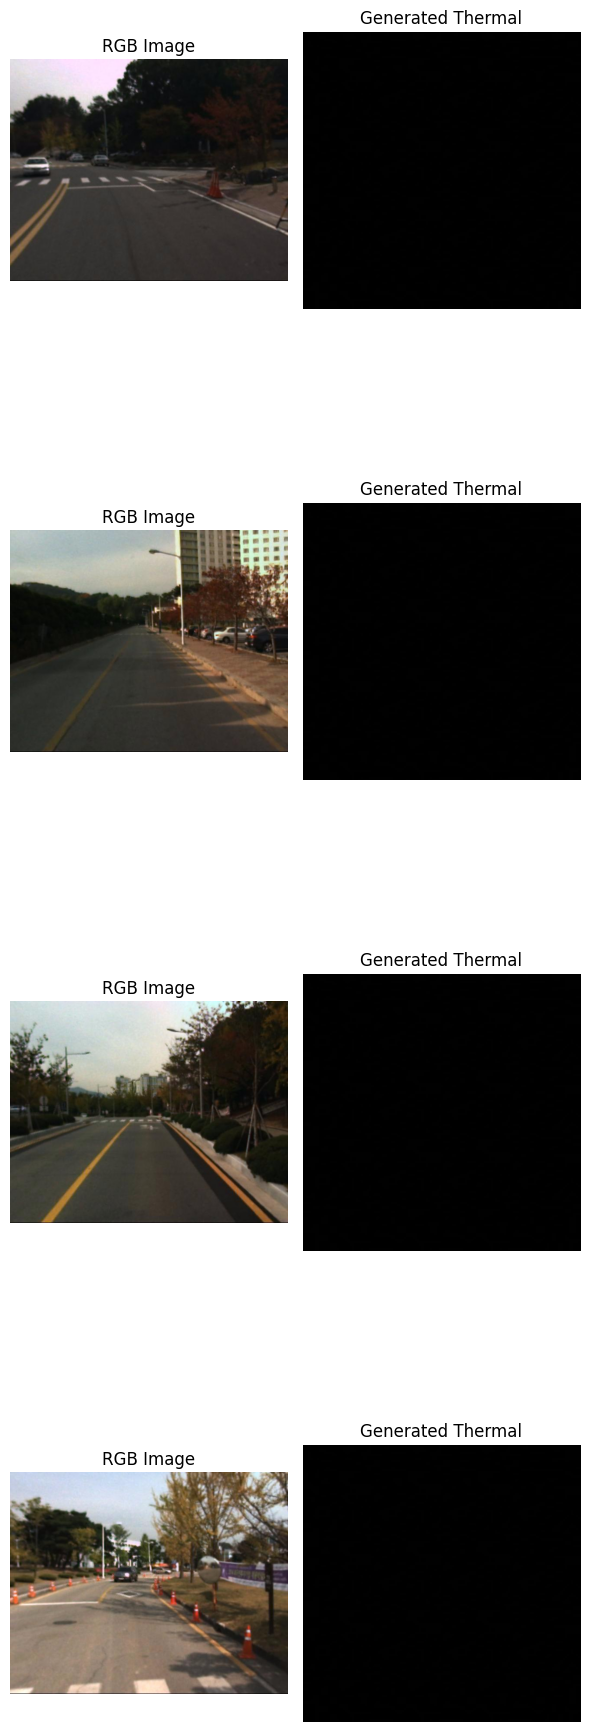

In [137]:
import matplotlib.pyplot as plt
import os
import cv2

# Directories containing your images
rgb_directory = 'ImageToImage/val/rgb'  
thermal_directory = 'ImageToImage/pix2piximage1keras' 
# List the files in the directories
rgb_images = os.listdir(rgb_directory)
thermal_images = os.listdir(thermal_directory)

# Take up to 4 pairs for visualization
num_pairs = min(4, min(len(rgb_images), len(thermal_images)))

# Plotting the image pairs
fig, axes = plt.subplots(num_pairs, 2, figsize=(6, num_pairs * 5))

for i in range(num_pairs):
    # Read the images
    rgb_image = cv2.imread(os.path.join(rgb_directory, rgb_images[i]))
    thermal_image = cv2.imread(os.path.join(thermal_directory, thermal_images[i]))

    # Convert BGR to RGB
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    thermal_image = cv2.cvtColor(thermal_image, cv2.COLOR_BGR2RGB)

    # Plot the images
    axes[i, 0].imshow(rgb_image)
    axes[i, 0].set_title('RGB Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(thermal_image)
    axes[i, 1].set_title('Generated Thermal')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()